          Date  Sales
0     1/1/2012  23.16
1     2/1/2012  22.95
2     3/1/2012  23.28
3     4/1/2012  24.06
4     5/1/2012  24.40
..         ...    ...
128   9/1/2022  47.00
129  10/1/2022  46.86
130  11/1/2022  45.48
131  12/1/2022  43.61
132   1/1/2023  41.33

[133 rows x 2 columns]
          Date  Sales  sales_diff
1     2/1/2012  22.95       -0.21
2     3/1/2012  23.28        0.33
3     4/1/2012  24.06        0.78
4     5/1/2012  24.40        0.34
5     6/1/2012  24.36       -0.04
..         ...    ...         ...
128   9/1/2022  47.00       -0.24
129  10/1/2022  46.86       -0.14
130  11/1/2022  45.48       -1.38
131  12/1/2022  43.61       -1.87
132   1/1/2023  41.33       -2.28

[132 rows x 3 columns]
          Date  Sales  sales_diff
1     2/1/2012  22.95       -0.21
2     3/1/2012  23.28        0.33
3     4/1/2012  24.06        0.78
4     5/1/2012  24.40        0.34
5     6/1/2012  24.36       -0.04
..         ...    ...         ...
128   9/1/2022  47.00       -0.24
129  10/

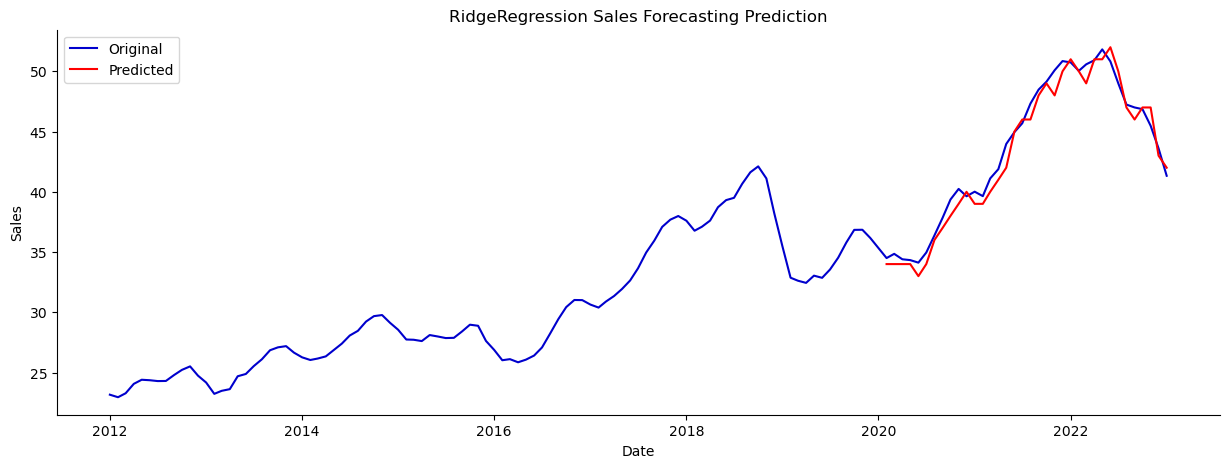

In [34]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime





from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Ridge





def get_diff(data):
    """Returns the dataframe with a column for sales difference between each
    month. Results in a stationary time series dataframe. Prior EDA revealed
    that the monthly data was not stationary as it had a time-dependent mean.
    """
    data['sales_diff'] = data.Sales.diff()
    data = data.dropna()
    print(data)
    data.to_csv('stationary_df.csv')

    return data


def generate_supervised(data):
    """Generates a csv file where each row represents a month and columns
    include sales, the dependent variable, and prior sales for each lag. Based
    on EDA, 12 lag features are generated. Data is used for regression modeling.
    Output df:
    month1  sales  lag1  lag2  lag3 ... lag11 lag12
    month2  sales  lag1  lag2  lag3 ... lag11 lag12
    """
    supervised_df = data.copy()

    #create column for each lag
    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    supervised_df.to_csv('model_df.csv', index=False)


def tts(data):
    data = data.drop(['Sales','Date'],axis=1)
    train, test = data[0:-36].values, data[-36:].values
    
    return train, test

def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

def undo_scaling(y_pred, x_test, scaler_obj):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('semic1.csv')
    
    original_df.Date = pd.to_datetime(original_df.Date)
    
    return original_df
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    
    sales_dates = list(original_df[-37:].Date)
    act_sales = list(original_df[-37:].Sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['Date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result


def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.Sales[-36:], unscaled_df.pred_value[-36:]))
    mae = mean_absolute_error(original_df.Sales[-36:], unscaled_df.pred_value[-36:])
    r2 = r2_score(original_df.Sales[-36:], unscaled_df.pred_value[-36:])
    #model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=original_df.Date, y=original_df.Sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(x=results.Date, y=results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'{model_name}_forecast.png')  
    

def run_model(train_data, test_data, model, model_name,t=0):
   
        X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)

        mod = model
        mod.fit(X_train, y_train)
        predictions = mod.predict(X_test)

        # Undo scaling to compare predictions against original data
        original_df = load_original_df()

        unscaled = undo_scaling(predictions, X_test, scaler_object)

        unscaled_df = predict_df(unscaled, original_df)

        get_scores(unscaled_df, original_df, model_name)

        plot_results(unscaled_df, original_df, model_name)
    
        

    
    
data=pd.read_csv('semic1.csv')
print(data)
stationary_df = get_diff(data)
print(stationary_df)
generate_supervised(stationary_df)


model_df = pd.read_csv('model_df.csv')
model_df    

train, test = tts(model_df)

print(train)
print(train.shape)
print(test)
print(test.shape)
# implementing RIDGE regression

#run_model(train, test,Ridge(alpha = 0.5), 'RidgeRegression')
X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

mod = Ridge(alpha = 0.5)
mod.fit(X_train, y_train)
print(X_test.shape)
predictions = mod.predict(X_test)

# Undo scaling to compare predictions against original data
original_df = load_original_df()

unscaled = undo_scaling(predictions, X_test, scaler_object)

unscaled_df = predict_df(unscaled, original_df)

get_scores(unscaled_df, original_df,'RidgeRegression')

plot_results(unscaled_df, original_df,'RidgeRegression')




In [14]:
ifdate=input("Enter date in m/d/yyyy:")
ifdate= pd.to_datetime(ifdate)
print(ifdate)
ndf=model_df
ndf['Date']

Enter date in m/d/yyyy:2/1/2023
2023-02-01 00:00:00


0       2/1/2013
1       3/1/2013
2       4/1/2013
3       5/1/2013
4       6/1/2013
         ...    
115     9/1/2022
116    10/1/2022
117    11/1/2022
118    12/1/2022
119     1/1/2023
Name: Date, Length: 120, dtype: object

In [79]:
df=pd.read_csv('semic1.csv')
print(df)
t=np.array([-2.280000000000001,-1.8699999999999974,-1.3800000000000026,-0.14000000000000057,-0.240000000000002,-1.759999999999998,-1.8200000000000003,-1.0,0.8999999999999986,0.3400000000000034,0.5399999999999991,-0.7000000000000028])
t=t.reshape(1,-1)
print(t.shape)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(t)

ts=scaler.transform(t)


tsy=mod.predict(ts)
#print(tsy.reshape(-1, 1))
print(tsy)
tem=np.array(tsy)
a=np.append(tsy,ts)

print(type(a))
scaler1 = MinMaxScaler(feature_range=(-1, 1))

scaler1 = scaler.fit(test)

oy=scaler1.inverse_transform(a.reshape(1,-1))
print(oy[:1,:1])
print(df['Sales'][132])
print("Predicted Value=",oy[:1,:1]+df['Sales'][132])

          Date  Sales
0     1/1/2012  23.16
1     2/1/2012  22.95
2     3/1/2012  23.28
3     4/1/2012  24.06
4     5/1/2012  24.40
..         ...    ...
128   9/1/2022  47.00
129  10/1/2022  46.86
130  11/1/2022  45.48
131  12/1/2022  43.61
132   1/1/2023  41.33

[133 rows x 2 columns]
(1, 12)
[-0.5432108]
<class 'numpy.ndarray'>
[[-1.28191559]]
41.33
Predicted Value= [[40.04808441]]
